## Imports & File Change (more efficient than uploading to Google Colab)


In [0]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive')

In [0]:
# importing of modules for LeNet CNN 
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout, SpatialDropout2D
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import LeakyReLU

# importing of service libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import matplotlib.ticker as mtick
import time as t
import pandas as pd
import seaborn as sns

print('Libraries imported.')

Using TensorFlow backend.


Libraries imported.


## Load Data

In [0]:
# Load data and split 
X = np.load('X.npy')
y = np.load('y.npy')

# Set-up input/output sizes
img_rows, img_cols = 128, 1290 # input  dimensions of each image
n_classes = 5  # number of outputs = number of digits
input_shape = (1, img_rows, img_cols)

print('Main variables initialised.')

Main variables initialised.


## Define Model Evaluation

In [0]:
def std_interval(data):
  means = []
  for i in data:
    means.append(np.mean(i))
  std = np.std(means)
  std_int = 1.96 * std
  return std_int

def ci_intervals(means, std_int):
  lower = []
  upper = []
  for i in means:
    lower.append(i - std_int)
    upper.append(i + std_int)
  return lower, upper

def plots(train_accuracy, val_accuracy):
  train_std = std_interval(train_accuracy)
  val_std = std_interval(val_accuracy)

  train_mean = list_averages(train_accuracy)
  val_mean = list_averages(val_accuracy)

  train_lower, train_upper = ci_intervals(train_mean, train_std)
  val_lower, val_upper = ci_intervals(val_mean, val_std)

  epochs = range(1, len(train_mean)+1)

  f, ax = plt.subplots(figsize=(8, 6))
  ax.grid(False)
  ax.plot(epochs, train_mean, color='green')
  ax.plot(epochs, val_mean, color='blue')
  ax.plot(epochs, train_lower,color='grey',linewidth=.1)
  ax.plot(epochs, train_upper,color='grey',linewidth=.1)
  ax.plot(epochs, val_lower,color='grey',linewidth=.1)
  ax.plot(epochs, val_upper,color='grey',linewidth=.1)

  ax.fill_between(epochs, train_lower,train_upper,alpha=.1,color='grey',interpolate=True)
  ax.fill_between(epochs, val_lower,val_upper,alpha=.1,color='grey',interpolate=True)
  
  ax.set_xticks(range(1, len(train_mean)+1, 2))
  
  return ax

def plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy):
  # Print summary statistic
  avg_test_loss = np.mean(test_loss)
  avg_test_acc = np.mean(test_accuracy)
  print("The test loss is: "+str(avg_test_loss))
  print("The test accuracy is: "+str(avg_test_acc))

  # summarize history for accuracy
  acc_ax = plots(train_accuracy, val_accuracy)
  acc_ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
  acc_ax.legend(["Average Train Accuracy", "Average Validation Accuracy","95% probability interval"],prop={'size': 10})
  acc_ax.set_xlabel('Number of Epochs', fontweight='bold')
  acc_ax.set_ylabel('Classification Accuracy', fontweight='bold')
  acc_ax.set_title('Model Accuracy at each Epoch', fontweight='bold')
  plt.show()
  # summarize history for loss
  loss_ax = plots(train_loss, val_loss)
  loss_ax.legend(["Average Train Loss", "Average Validation Loss","95% probability interval"],prop={'size': 10})
  loss_ax.set_xlabel('Number of Epochs', fontweight='bold')
  loss_ax.set_ylabel('Loss', fontweight='bold')
  loss_ax.set_title('Model Loss at each Epoch', fontweight='bold')
  plt.show()

def list_averages(scores):
  full_avg_scores = []
  for i in range(len(scores[0])):
    avg_scores = []
    for j in range(len(scores)):
      avg_scores.append(scores[j][i])
    full_avg_scores.append(np.mean(avg_scores))
  return full_avg_scores

def draw_conf_matrix(X_test, y_test):
  predict = model.predict_classes(X_test)
  conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred)
  sns.set(rc={'figure.figsize':(8,6)})
  ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', cbar=False, fmt='g', annot_kws={"size":13})
  ax.set_xlabel('Predicted Genre', fontweight='bold')
  ax.set_ylabel('Actual Genre', fontweight='bold')
  ax.xaxis.set_ticklabels(['Blues', 'Classical', 'Hiphop', 'Metal', 'Disco'], ha='center')
  ax.yaxis.set_ticklabels(['Blues', 'Classical', 'Hiphop', 'Metal', 'Disco'], va='center')
  ax.set_title('Confusion Matrix of Genre Classification', fontweight='bold')
  plt.show(ax)
  return ax


## Define model fit and base model

In [0]:
def fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense):
  model = Model(input_shape, n_classes, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])
  print(model.summary())
  model.save_weights('model.h5')
  # seed for reproducibility
  test_accuracy, test_loss = [], []
  train_accuracy, train_loss = [], []
  val_accuracy, val_loss = [], []
  for i in range(1,10):
    model.load_weights('model.h5')
    seed = random.randint(1,500)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = seed, test_size = 0.2, shuffle = True)
    fit_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split = 0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    train_accuracy.append(fit_model.history['acc'])
    train_loss.append(fit_model.history['loss'])
    val_accuracy.append(fit_model.history['val_acc'])
    val_loss.append(fit_model.history['val_loss'])
    test_loss.append(score[0])
    test_accuracy.append(score[1])


  return train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy

def LeNet(input_shape, classes, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense):
  model = Sequential()

  # CONV => RELU => POOL
  model.add(Conv2D(batch1, kernel_size=k_size, strides = conv_stride,  padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=p_size, strides= pool_stride, dim_ordering="th"))

  # CONV => RELU => POOL
  model.add(Conv2D(batch2, kernel_size=k_size, strides = conv_stride,  padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=p_size, strides= pool_stride, dim_ordering="th"))

  # Flatten => RELU layers
  model.add(Flatten())
  model.add(Dense(dense))
  model.add(Activation("relu"))

  # a softmax classifier
  model.add(Dense(classes))

  model.add(Activation("softmax"))

  return model

  print('LeNet class defined.')

## Create & Evaluate Base Model


In [0]:
n_epoch = 20
batch_size = 25
Model = LeNet
lr = 0.001
optimizer = Adam(lr)
batch1 = 32
batch2 = 32
k_size = (3, 3)
conv_stride = (3, 3) 
p_size = (3, 3)
pool_stride = (3, 3) 
dense =  128

train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy)

## Parameter Tuning
### Note that this method iteratively improves each parameter, which is far less effective than grid search.
### However, it is by far less computationally costly and results are still acceptable.

In [0]:
score_df = pd.DataFrame(columns = ['Parameter', 'Accuracy', 'Loss'])

In [0]:
parameter = 'Kernel Size: '
k_sizes = [(3, 3), (5, 5), (7, 7), (1, 5), (5, 1), (1, 7), (7, 1)]

for k_size in k_sizes:
  train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  parameter_name = parameter+str(k_size)
  parameter_acc = np.mean(test_accuracy)
  parameter_loss = np.mean(test_loss)
  score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 1, 43, 32)         371552    
_________________________________________________________________
activation_71 (Activation)   (None, 1, 43, 32)         0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 1, 14, 10)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 1, 5, 32)          2912      
_________________________________________________________________
activation_72 (Activation)   (None, 1, 5, 32)          0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 1, 1, 10)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 10)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 6ms/step - loss: 1.8043 - acc: 0.2375 - val_loss: 1.3049 - val_acc: 0.4125
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.2209 - acc: 0.5062 - val_loss: 1.2206 - val_acc: 0.4875
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.9586 - acc: 0.5844 - val_loss: 1.3417 - val_acc: 0.5500
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.6509 - acc: 0.7531 - val_loss: 1.2609 - val_acc: 0.5375
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.3982 - acc: 0.8875 - val_loss: 1.3714 - val_acc: 0.5375
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2433 - acc: 0.9312 - val_loss: 1.6384 - val_acc: 0.5625
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1467 - acc: 0.9687 - val_loss: 1.6891 - val_acc: 0.5250
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 7ms/step - loss: 1.6994 - acc: 0.2875 - val_loss: 1.6729 - val_acc: 0.2750
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.3829 - acc: 0.4531 - val_loss: 1.3178 - val_acc: 0.4750
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.9872 - acc: 0.6187 - val_loss: 1.0709 - val_acc: 0.5875
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.6688 - acc: 0.7625 - val_loss: 1.1170 - val_acc: 0.6375
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.3468 - acc: 0.8687 - val_loss: 1.1525 - val_acc: 0.6000
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2012 - acc: 0.9312 - val_loss: 1.3162 - val_acc: 0.6500
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.0850 - acc: 0.9719 - val_loss: 1.3557 - val_acc: 0.6375
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 7ms/step - loss: 2.9915 - acc: 0.2563 - val_loss: 2.1824 - val_acc: 0.4000
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.6185 - acc: 0.4500 - val_loss: 1.2888 - val_acc: 0.4875
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 1.0231 - acc: 0.6312 - val_loss: 1.3958 - val_acc: 0.5625
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.6963 - acc: 0.7281 - val_loss: 1.0691 - val_acc: 0.5125
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.4137 - acc: 0.8719 - val_loss: 1.2279 - val_acc: 0.6125
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2283 - acc: 0.9406 - val_loss: 1.1549 - val_acc: 0.5625
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1540 - acc: 0.9687 - val_loss: 1.2430 - val_acc: 0.5750
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 7ms/step - loss: 1.7451 - acc: 0.1625 - val_loss: 1.5991 - val_acc: 0.2500
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.5842 - acc: 0.2469 - val_loss: 1.6984 - val_acc: 0.1750
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 1.4283 - acc: 0.3844 - val_loss: 1.5937 - val_acc: 0.2625
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 1.1539 - acc: 0.5187 - val_loss: 1.7308 - val_acc: 0.2625
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.8417 - acc: 0.6875 - val_loss: 2.0437 - val_acc: 0.3375
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.6019 - acc: 0.8000 - val_loss: 2.2928 - val_acc: 0.3125
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.3972 - acc: 0.8812 - val_loss: 2.9394 - val_acc: 0.3000
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 7ms/step - loss: 2.5701 - acc: 0.2875 - val_loss: 2.4702 - val_acc: 0.2625
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.5018 - acc: 0.4875 - val_loss: 1.6211 - val_acc: 0.3750
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 0.8933 - acc: 0.6937 - val_loss: 1.5496 - val_acc: 0.4250
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 0.6142 - acc: 0.7594 - val_loss: 1.2768 - val_acc: 0.5500
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.3224 - acc: 0.8812 - val_loss: 1.6940 - val_acc: 0.4500
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.2271 - acc: 0.9156 - val_loss: 1.7816 - val_acc: 0.4750
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.1189 - acc: 0.9750 - val_loss: 2.0792 - val_acc: 0.4375
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 2s 7ms/step - loss: 1.6792 - acc: 0.2187 - val_loss: 1.4721 - val_acc: 0.4250
Epoch 2/10
320/320 [==============================] - 0s 1ms/step - loss: 1.5430 - acc: 0.2781 - val_loss: 1.5446 - val_acc: 0.2375
Epoch 3/10
320/320 [==============================] - 0s 1ms/step - loss: 1.4493 - acc: 0.3594 - val_loss: 1.6541 - val_acc: 0.3250
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 1.1733 - acc: 0.5031 - val_loss: 1.7640 - val_acc: 0.3375
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.9455 - acc: 0.6344 - val_loss: 2.2943 - val_acc: 0.3250
Epoch 6/10
320/320 [==============================] - 0s 1ms/step - loss: 0.7547 - acc: 0.6938 - val_loss: 2.3330 - val_acc: 0.3500
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.5473 - acc: 0.8219 - val_loss: 2.5993 - val_acc: 0.2500
Epoch 8/10
320/320 [===========

In [0]:
score_df

,Parameter,Accuracy,Loss
0,"Kernel Size: (3, 3)",0.473333,1.981357
1,"Kernel Size: (5, 5)",0.565556,1.611662
2,"Kernel Size: (7, 7)",0.588889,1.577976
3,"Kernel Size: (1, 5)",0.533333,1.530358
4,"Kernel Size: (5, 1)",0.368889,1.725819
5,"Kernel Size: (1, 7)",0.557778,1.488459
6,"Kernel Size: (7, 1)",0.407778,1.746344


In [0]:
k_size = (7, 7)

parameter = 'Conv Strides: '
conv_strides = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 1), (3, 1), (1, 3)]
for conv_stride in conv_strides:
  train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  parameter_name = parameter+str(conv_stride)
  parameter_acc = np.mean(test_accuracy)
  parameter_loss = np.mean(test_loss)
  score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 1, 128, 32)        2022752   
_________________________________________________________________
activation_99 (Activation)   (None, 1, 128, 32)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 1, 42, 10)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 42, 32)         15712     
_________________________________________________________________
activation_100 (Activation)  (None, 1, 42, 32)         0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 1, 14, 10)         0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 140)             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 9ms/step - loss: 3.7840 - acc: 0.2969 - val_loss: 3.0019 - val_acc: 0.2500
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.9445 - acc: 0.3563 - val_loss: 1.5891 - val_acc: 0.3625
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 1.2250 - acc: 0.5187 - val_loss: 1.4693 - val_acc: 0.4375
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 1.1015 - acc: 0.5625 - val_loss: 1.1904 - val_acc: 0.5625
Epoch 5/10
320/320 [==============================] - 0s 2ms/step - loss: 1.0092 - acc: 0.5656 - val_loss: 1.4779 - val_acc: 0.4125
Epoch 6/10
320/320 [==============================] - 0s 2ms/step - loss: 0.7836 - acc: 0.7094 - val_loss: 1.0896 - val_acc: 0.5125
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.4998 - acc: 0.8188 - val_loss: 1.2789 - val_acc: 0.5625
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 9ms/step - loss: 1.9322 - acc: 0.2687 - val_loss: 2.0490 - val_acc: 0.3125
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.2064 - acc: 0.5312 - val_loss: 1.3885 - val_acc: 0.4125
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 0.8877 - acc: 0.6125 - val_loss: 1.3442 - val_acc: 0.5250
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 0.7189 - acc: 0.7281 - val_loss: 1.4961 - val_acc: 0.5875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.4410 - acc: 0.8500 - val_loss: 1.4761 - val_acc: 0.5625
Epoch 6/10
320/320 [==============================] - 0s 2ms/step - loss: 0.1728 - acc: 0.9437 - val_loss: 1.8344 - val_acc: 0.5500
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.0712 - acc: 0.9781 - val_loss: 1.9749 - val_acc: 0.5375
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 9ms/step - loss: 3.7528 - acc: 0.2031 - val_loss: 1.7706 - val_acc: 0.2875
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.6669 - acc: 0.3937 - val_loss: 1.3293 - val_acc: 0.4250
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 1.2659 - acc: 0.4469 - val_loss: 1.2757 - val_acc: 0.5625
Epoch 4/10
320/320 [==============================] - 0s 1ms/step - loss: 1.0285 - acc: 0.6062 - val_loss: 1.0512 - val_acc: 0.5750
Epoch 5/10
320/320 [==============================] - 0s 1ms/step - loss: 0.7426 - acc: 0.7063 - val_loss: 1.1591 - val_acc: 0.5875
Epoch 6/10
320/320 [==============================] - 0s 2ms/step - loss: 0.4984 - acc: 0.8375 - val_loss: 1.0768 - val_acc: 0.6500
Epoch 7/10
320/320 [==============================] - 0s 1ms/step - loss: 0.3593 - acc: 0.8937 - val_loss: 1.2254 - val_acc: 0.5500
Epoch 8/10
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 10ms/step - loss: 10.7266 - acc: 0.2219 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 10ms/step - loss: 11.6394 - acc: 0.2187 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 3s 10ms/step - loss: 2.0450 - acc: 0.2406 - val_loss: 1.6081 - val_acc: 0.2750
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.5474 - acc: 0.3313 - val_loss: 1.4882 - val_acc: 0.3125
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.1794 - acc: 0.4875 - val_loss: 1.2797 - val_acc: 0.4375
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 0.8167 - acc: 0.6781 - val_loss: 1.0659 - val_acc: 0.6000
Epoch 5/10
320/320 [==============================] - 0s 2ms/step - loss: 0.5232 - acc: 0.8063 - val_loss: 1.2477 - val_acc: 0.5375
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.2984 - acc: 0.9031 - val_loss: 1.1978 - val_acc: 0.5875
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.1664 - acc: 0.9500 - val_loss: 1.1563 - val_acc: 0.5750
Epoch 8/10
320/320 [==========

In [0]:
score_df 

,Parameter,Accuracy,Loss
0,"Kernel Size: (3, 3)",0.473333,1.981357
1,"Kernel Size: (5, 5)",0.565556,1.611662
2,"Kernel Size: (7, 7)",0.588889,1.577976
3,"Kernel Size: (1, 5)",0.533333,1.530358
4,"Kernel Size: (5, 1)",0.368889,1.725819
5,"Kernel Size: (1, 7)",0.557778,1.488459
6,"Kernel Size: (7, 1)",0.407778,1.746344
7,"Conv Strides: (1, 1)",0.504444,5.114644
8,"Conv Strides: (2, 2)",0.595556,1.339987
9,"Conv Strides: (3, 3)",0.602222,1.447754


In [0]:
conv_stride = (1, 2)

parameter = 'Batch Size: '
batch_sizes = [32, 64, 128]

for batch1 in batch_sizes:
  for batch2 in batch_sizes:
    train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                            optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
    parameter_name = parameter+str(batch1)+"x"+str(batch2)
    parameter_acc = np.mean(test_accuracy)
    parameter_loss = np.mean(test_loss)
    score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_75 (Conv2D)           (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_147 (Activation)  (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 1, 21, 10)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 1, 11, 32)         15712     
_________________________________________________________________
activation_148 (Activation)  (None, 1, 11, 32)         0         
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 1, 3, 10)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 30)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 4s 13ms/step - loss: 4.4255 - acc: 0.2125 - val_loss: 2.9770 - val_acc: 0.2750
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.9945 - acc: 0.3125 - val_loss: 1.4823 - val_acc: 0.3250
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4181 - acc: 0.4344 - val_loss: 1.3877 - val_acc: 0.4250
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 1.1906 - acc: 0.4969 - val_loss: 1.2300 - val_acc: 0.4750
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9758 - acc: 0.6031 - val_loss: 1.4112 - val_acc: 0.4375
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.8896 - acc: 0.6563 - val_loss: 1.1091 - val_acc: 0.5375
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6149 - acc: 0.7375 - val_loss: 1.1984 - val_acc: 0.5625
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 4s 14ms/step - loss: 5.2042 - acc: 0.2281 - val_loss: 4.5687 - val_acc: 0.2250
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 2.1643 - acc: 0.3656 - val_loss: 1.2520 - val_acc: 0.5625
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.2359 - acc: 0.5344 - val_loss: 1.1154 - val_acc: 0.5500
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9879 - acc: 0.5719 - val_loss: 1.0625 - val_acc: 0.6000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.8869 - acc: 0.6281 - val_loss: 1.0544 - val_acc: 0.5750
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6530 - acc: 0.7313 - val_loss: 0.8874 - val_acc: 0.7125
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.4632 - acc: 0.8437 - val_loss: 0.9276 - val_acc: 0.6500
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 15ms/step - loss: 7.0998 - acc: 0.2031 - val_loss: 8.0783 - val_acc: 0.3750
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 6.6572 - acc: 0.3781 - val_loss: 6.2168 - val_acc: 0.3500
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 3.6106 - acc: 0.3750 - val_loss: 1.4903 - val_acc: 0.2750
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 1.5838 - acc: 0.2219 - val_loss: 1.6040 - val_acc: 0.1875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 1.6058 - acc: 0.1875 - val_loss: 1.6150 - val_acc: 0.1750
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 1.6017 - acc: 0.2062 - val_loss: 1.6178 - val_acc: 0.1750
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 1.5994 - acc: 0.2031 - val_loss: 1.6205 - val_acc: 0.1500
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 14ms/step - loss: 11.3217 - acc: 0.2187 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2063 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2063 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 14ms/step - loss: 11.7128 - acc: 0.1938 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 15ms/step - loss: 10.8820 - acc: 0.2000 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 15ms/step - loss: 11.4225 - acc: 0.1750 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 16ms/step - loss: 11.8572 - acc: 0.2062 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/10
320/3

In [0]:
score_df

,Unnamed: 0,Parameter,Accuracy,Loss
0,0.0,"Kernel Size: (3, 3)",0.473333,1.981357
1,1.0,"Kernel Size: (5, 5)",0.565556,1.611662
2,2.0,"Kernel Size: (7, 7)",0.588889,1.577976
3,3.0,"Kernel Size: (1, 5)",0.533333,1.530358
4,4.0,"Kernel Size: (5, 1)",0.368889,1.725819
5,5.0,"Kernel Size: (1, 7)",0.557778,1.488459
6,6.0,"Kernel Size: (7, 1)",0.407778,1.746344
7,7.0,"Conv Strides: (1, 1)",0.504444,5.114644
8,8.0,"Conv Strides: (2, 2)",0.595556,1.339987
9,9.0,"Conv Strides: (3, 3)",0.602222,1.447754


In [0]:
batch1 = 32
batch2 = 64

parameter = 'Pool Size: '
pool_sizes = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 1), (1, 3), (3, 1)]

for p_size in pool_sizes:
  train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  parameter_name = parameter+str(p_size)
  parameter_acc = np.mean(test_accuracy)
  parameter_loss = np.mean(test_loss)
  score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 1), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 1), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_183 (Activation)  (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 1, 22, 11)         0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 1, 11, 64)         34560     
_________________________________________________________________
activation_184 (Activation)  (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 1, 4, 22)          0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 88)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 16ms/step - loss: 4.4103 - acc: 0.2094 - val_loss: 2.1165 - val_acc: 0.3125
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.7761 - acc: 0.3594 - val_loss: 1.0209 - val_acc: 0.6250
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 1.0732 - acc: 0.5219 - val_loss: 0.7878 - val_acc: 0.7000
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 0.8498 - acc: 0.6688 - val_loss: 0.8277 - val_acc: 0.7000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.7531 - acc: 0.7000 - val_loss: 0.7970 - val_acc: 0.7250
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.5226 - acc: 0.8437 - val_loss: 0.9401 - val_acc: 0.6750
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.3908 - acc: 0.8500 - val_loss: 0.8510 - val_acc: 0.6750
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 16ms/step - loss: 5.0317 - acc: 0.2312 - val_loss: 3.4245 - val_acc: 0.4000
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 2.1306 - acc: 0.3313 - val_loss: 1.6547 - val_acc: 0.3875
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.2426 - acc: 0.4906 - val_loss: 1.0713 - val_acc: 0.5500
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 1.0702 - acc: 0.4969 - val_loss: 1.0266 - val_acc: 0.5250
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9492 - acc: 0.5875 - val_loss: 0.9823 - val_acc: 0.5500
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.7964 - acc: 0.6938 - val_loss: 0.8312 - val_acc: 0.6750
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.6106 - acc: 0.7656 - val_loss: 0.9540 - val_acc: 0.6250
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 2), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 2), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 16ms/step - loss: 3.3080 - acc: 0.2969 - val_loss: 2.1777 - val_acc: 0.4125
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.5913 - acc: 0.4063 - val_loss: 1.2371 - val_acc: 0.5000
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.1534 - acc: 0.5500 - val_loss: 1.1822 - val_acc: 0.5500
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9004 - acc: 0.6500 - val_loss: 1.1192 - val_acc: 0.6125
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.7891 - acc: 0.7031 - val_loss: 1.1555 - val_acc: 0.5750
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.5788 - acc: 0.8031 - val_loss: 1.1401 - val_acc: 0.6625
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.4080 - acc: 0.8812 - val_loss: 1.2493 - val_acc: 0.6625
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 1), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 1), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 17ms/step - loss: 2.4611 - acc: 0.2750 - val_loss: 2.1574 - val_acc: 0.3125
Epoch 2/10
320/320 [==============================] - 0s 2ms/step - loss: 1.4211 - acc: 0.3937 - val_loss: 1.2671 - val_acc: 0.4500
Epoch 3/10
320/320 [==============================] - 0s 2ms/step - loss: 1.0890 - acc: 0.5438 - val_loss: 1.1353 - val_acc: 0.5500
Epoch 4/10
320/320 [==============================] - 0s 2ms/step - loss: 0.9519 - acc: 0.6250 - val_loss: 1.0337 - val_acc: 0.5000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.7320 - acc: 0.6969 - val_loss: 1.0526 - val_acc: 0.5500
Epoch 6/10
320/320 [==============================] - 0s 2ms/step - loss: 0.5767 - acc: 0.7750 - val_loss: 1.0196 - val_acc: 0.6500
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 0.5054 - acc: 0.7969 - val_loss: 1.1139 - val_acc: 0.5875
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 5s 17ms/step - loss: 3.0293 - acc: 0.2812 - val_loss: 1.8736 - val_acc: 0.5375
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4493 - acc: 0.4562 - val_loss: 1.3190 - val_acc: 0.4500
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9513 - acc: 0.6469 - val_loss: 1.2030 - val_acc: 0.5750
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6556 - acc: 0.7281 - val_loss: 1.0100 - val_acc: 0.5875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3491 - acc: 0.8906 - val_loss: 0.9691 - val_acc: 0.6375
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1873 - acc: 0.9656 - val_loss: 1.1212 - val_acc: 0.5625
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.1105 - acc: 0.9781 - val_loss: 1.1191 - val_acc: 0.6625
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 1), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 1), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 17ms/step - loss: 2.6207 - acc: 0.2563 - val_loss: 1.3904 - val_acc: 0.4375
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4376 - acc: 0.4156 - val_loss: 1.4209 - val_acc: 0.3875
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.2173 - acc: 0.4500 - val_loss: 1.4431 - val_acc: 0.4375
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9504 - acc: 0.5969 - val_loss: 1.2304 - val_acc: 0.4500
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6878 - acc: 0.7125 - val_loss: 1.3019 - val_acc: 0.5875
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.4832 - acc: 0.8156 - val_loss: 1.3417 - val_acc: 0.5875
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3689 - acc: 0.8875 - val_loss: 1.4374 - val_acc: 0.5625
Epoch 8/10
320/320 [==========

In [0]:
score_df

,Unnamed: 0,Parameter,Accuracy,Loss
0,0.0,"Kernel Size: (3, 3)",0.473333,1.981357
1,1.0,"Kernel Size: (5, 5)",0.565556,1.611662
2,2.0,"Kernel Size: (7, 7)",0.588889,1.577976
3,3.0,"Kernel Size: (1, 5)",0.533333,1.530358
4,4.0,"Kernel Size: (5, 1)",0.368889,1.725819
5,5.0,"Kernel Size: (1, 7)",0.557778,1.488459
6,6.0,"Kernel Size: (7, 1)",0.407778,1.746344
7,7.0,"Conv Strides: (1, 1)",0.504444,5.114644
8,8.0,"Conv Strides: (2, 2)",0.595556,1.339987
9,9.0,"Conv Strides: (3, 3)",0.602222,1.447754


In [0]:
p_size = (1, 3)

parameter = 'Pool Strides: '
pool_strides = [(1, 1), (2, 2), (3, 3), (1, 2), (2, 1), (3, 1), (1, 3)]

for pool_stride in pool_strides:
  train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  parameter_name = parameter+str(pool_stride)
  parameter_acc = np.mean(test_accuracy)
  parameter_loss = np.mean(test_loss)
  score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 1), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 1), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_211 (Activation)  (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 1, 64, 30)         0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 1, 32, 64)         94144     
_________________________________________________________________
activation_212 (Activation)  (None, 1, 32, 64)         0         
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 1, 32, 62)         0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 1984)            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(2, 2), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(2, 2), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 18ms/step - loss: 11.1999 - acc: 0.1656 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 18ms/step - loss: 5.0154 - acc: 0.2719 - val_loss: 2.2093 - val_acc: 0.4125
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.7905 - acc: 0.4281 - val_loss: 1.1526 - val_acc: 0.5375
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9515 - acc: 0.6125 - val_loss: 0.8976 - val_acc: 0.6625
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 0.9827 - acc: 0.6125 - val_loss: 0.9047 - val_acc: 0.6875
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6796 - acc: 0.7219 - val_loss: 1.0856 - val_acc: 0.6250
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.4384 - acc: 0.8313 - val_loss: 1.1318 - val_acc: 0.6750
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.3392 - acc: 0.9031 - val_loss: 1.1363 - val_acc: 0.6750
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 2), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 2), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 18ms/step - loss: 11.9109 - acc: 0.1906 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(2, 1), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(2, 1), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 19ms/step - loss: 11.5397 - acc: 0.2094 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 13.0960 - acc: 0.1875 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 1), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 1), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 19ms/step - loss: 11.5612 - acc: 0.1969 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 8/10
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(1, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 6s 20ms/step - loss: 12.0102 - acc: 0.2156 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 12.4915 - acc: 0.2250 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/10
320/3

In [0]:
score_df

,Unnamed: 0,Parameter,Accuracy,Loss
0,0.0,"Kernel Size: (3, 3)",0.473333,1.981357
1,1.0,"Kernel Size: (5, 5)",0.565556,1.611662
2,2.0,"Kernel Size: (7, 7)",0.588889,1.577976
3,3.0,"Kernel Size: (1, 5)",0.533333,1.530358
4,4.0,"Kernel Size: (5, 1)",0.368889,1.725819
5,5.0,"Kernel Size: (1, 7)",0.557778,1.488459
6,6.0,"Kernel Size: (7, 1)",0.407778,1.746344
7,7.0,"Conv Strides: (1, 1)",0.504444,5.114644
8,8.0,"Conv Strides: (2, 2)",0.595556,1.339987
9,9.0,"Conv Strides: (3, 3)",0.602222,1.447754


In [0]:
pool_stride = (3, 3)

parameter = 'Dense: '
dense_sizes = [128, 256, 512]

for dense in dense_sizes:
  train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
  parameter_name = parameter+str(dense)
  parameter_acc = np.mean(test_accuracy)
  parameter_loss = np.mean(test_loss)
  score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_239 (Activation)  (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 1, 22, 10)         0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 1, 11, 64)         31424     
_________________________________________________________________
activation_240 (Activation)  (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 1, 4, 21)          0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 84)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 7s 21ms/step - loss: 5.1206 - acc: 0.2406 - val_loss: 1.8781 - val_acc: 0.2625
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4703 - acc: 0.3906 - val_loss: 1.6975 - val_acc: 0.2750
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.5524 - acc: 0.2469 - val_loss: 1.5374 - val_acc: 0.3875
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4474 - acc: 0.3656 - val_loss: 1.2798 - val_acc: 0.4500
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 1.3241 - acc: 0.4562 - val_loss: 1.2489 - val_acc: 0.5000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 1.2471 - acc: 0.4875 - val_loss: 1.2737 - val_acc: 0.4625
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 1.2030 - acc: 0.5031 - val_loss: 1.3150 - val_acc: 0.5125
Epoch 8/10
320/320 [==========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 7s 21ms/step - loss: 2.5304 - acc: 0.2656 - val_loss: 1.5314 - val_acc: 0.2250
Epoch 2/10
320/320 [==============================] - 1s 2ms/step - loss: 1.5114 - acc: 0.3812 - val_loss: 1.5283 - val_acc: 0.2750
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4908 - acc: 0.3312 - val_loss: 1.5414 - val_acc: 0.2750
Epoch 4/10
320/320 [==============================] - 1s 2ms/step - loss: 1.4351 - acc: 0.3625 - val_loss: 1.4410 - val_acc: 0.3500
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 1.3906 - acc: 0.3594 - val_loss: 1.4390 - val_acc: 0.3000
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 1.3613 - acc: 0.3750 - val_loss: 1.3836 - val_acc: 0.3125
Epoch 7/10
320/320 [==============================] - 0s 2ms/step - loss: 1.2655 - acc: 0.4125 - val_loss: 1.4177 - val_acc: 0.4000
Epoch 8/10
320/320 [==========

In [0]:
score_df = pd.read_csv('score_df.csv')

In [0]:
dense = 256

parameter = 'Epochs, Batch Size, Learning Rate: '
epochs = [8, 12, 16]
batch_sizes = [10, 25, 50]
learning_rates = [0.0001, 0.001, 0.01]

for n_epoch in epochs:
  for batch_size in batch_sizes:
    for lr in learning_rates:
      optimizer = Adam(lr)
      train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
      parameter_name = parameter+str(n_epoch)+" "+str(batch_size)+" "+str(lr)
      parameter_acc = np.mean(test_accuracy)
      parameter_loss = np.mean(test_loss)
      score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

score_df.to_csv('score_df.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys








Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_1 (Activation)    (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 22, 10)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 11, 64)         31424     
_________________________________________________________________
activation_2 (Activation)    (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 4, 21)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 84)         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 7s 22ms/step - loss: 1.5345 - acc: 0.2781 - val_loss: 1.4304 - val_acc: 0.4250
Epoch 2/8
320/320 [==============================] - 1s 3ms/step - loss: 1.2662 - acc: 0.4906 - val_loss: 1.2112 - val_acc: 0.5375
Epoch 3/8
320/320 [==============================] - 1s 3ms/step - loss: 1.0556 - acc: 0.5969 - val_loss: 1.1101 - val_acc: 0.5750
Epoch 4/8
320/320 [==============================] - 1s 3ms/step - loss: 0.8972 - acc: 0.6844 - val_loss: 1.0155 - val_acc: 0.5625
Epoch 5/8
320/320 [==============================] - 1s 3ms/step - loss: 0.7810 - acc: 0.7156 - val_loss: 0.9903 - val_acc: 0.5875
Epoch 6/8
320/320 [==============================] - 1s 3ms/step - loss: 0.6991 - acc: 0.7281 - val_loss: 0.9424 - val_acc: 0.6000
Epoch 7/8
320/320 [==============================] - 1s 3ms/step - loss:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 4ms/step - loss: 1.4026 - acc: 0.3719 - val_loss: 1.2031 - val_acc: 0.4750
Epoch 2/8
320/320 [==============================] - 1s 3ms/step - loss: 0.8583 - acc: 0.6656 - val_loss: 1.4364 - val_acc: 0.4875
Epoch 3/8
320/320 [==============================] - 1s 3ms/step - loss: 0.5547 - acc: 0.7844 - val_loss: 1.1120 - val_acc: 0.6125
Epoch 4/8
320/320 [==============================] - 1s 3ms/step - loss: 0.2949 - acc: 0.8969 - val_loss: 1.4640 - val_acc: 0.6500
Epoch 5/8
320/320 [==============================] - 1s 3ms/step - loss: 0.1032 - acc: 0.9687 - val_loss: 1.5387 - val_acc: 0.6000
Epoch 6/8
320/320 [==============================] - 1s 3ms/step - loss: 0.0356 - acc: 0.9969 - val_loss: 1.4705 - val_acc: 0.6125
Epoch 7/8
320/320 [==============================] - 1s 3ms/step - loss: 0.0131 - acc: 1.0000 - val_loss: 1.7130 - val_acc: 0.5875
Epoch 8/8
100/100 [===================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 4ms/step - loss: 12.9837 - acc: 0.1688 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 2/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 3/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 4/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 5/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 6/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 7/8
320/320 [==============================] - 1s 3ms/step - loss: 13.2471 - acc: 0.1781 - val_loss: 11.4841 - val_acc: 0.2875
Epoch 8/8
100/100 [=====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 5ms/step - loss: 1.5965 - acc: 0.2406 - val_loss: 1.5981 - val_acc: 0.2625
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 1.4680 - acc: 0.4375 - val_loss: 1.5521 - val_acc: 0.2375
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 1.3022 - acc: 0.5031 - val_loss: 1.4493 - val_acc: 0.3000
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 1.1499 - acc: 0.5344 - val_loss: 1.3382 - val_acc: 0.3750
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 1.0202 - acc: 0.5906 - val_loss: 1.2529 - val_acc: 0.4000
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 0.9070 - acc: 0.6594 - val_loss: 1.1649 - val_acc: 0.4750
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 0.8100 - acc: 0.7469 - val_loss: 1.1567 - val_acc: 0.5000
Epoch 8/8
100/100 [===================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 4ms/step - loss: 1.5034 - acc: 0.3063 - val_loss: 1.0379 - val_acc: 0.5875
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 1.0511 - acc: 0.5719 - val_loss: 1.0427 - val_acc: 0.5500
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 0.8165 - acc: 0.6875 - val_loss: 0.9123 - val_acc: 0.6625
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 0.6161 - acc: 0.7656 - val_loss: 0.9985 - val_acc: 0.6000
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 0.4576 - acc: 0.8188 - val_loss: 1.1427 - val_acc: 0.6125
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 0.2040 - acc: 0.9656 - val_loss: 0.9066 - val_acc: 0.7000
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 0.0971 - acc: 0.9906 - val_loss: 0.8518 - val_acc: 0.6875
Epoch 8/8
100/100 [===================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 4ms/step - loss: 11.5198 - acc: 0.2094 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/8
100/100 [=====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 2s 5ms/step - loss: 1.6006 - acc: 0.2688 - val_loss: 1.5798 - val_acc: 0.2000
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 1.5255 - acc: 0.2969 - val_loss: 1.5102 - val_acc: 0.3125
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 1.4171 - acc: 0.4719 - val_loss: 1.4232 - val_acc: 0.3875
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 1.2901 - acc: 0.5625 - val_loss: 1.3257 - val_acc: 0.4500
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 1.1581 - acc: 0.6094 - val_loss: 1.2336 - val_acc: 0.5125
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 1.0421 - acc: 0.6656 - val_loss: 1.1580 - val_acc: 0.5125
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 0.9471 - acc: 0.6781 - val_loss: 1.1097 - val_acc: 0.5375
Epoch 8/8
100/100 [===================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 1s 4ms/step - loss: 1.5228 - acc: 0.2437 - val_loss: 1.2867 - val_acc: 0.4500
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 1.1203 - acc: 0.5563 - val_loss: 1.0316 - val_acc: 0.6250
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 0.9753 - acc: 0.6187 - val_loss: 0.9470 - val_acc: 0.6500
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 0.7922 - acc: 0.6781 - val_loss: 0.8923 - val_acc: 0.6250
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 0.6570 - acc: 0.7562 - val_loss: 0.8644 - val_acc: 0.6875
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 0.5168 - acc: 0.8125 - val_loss: 0.9210 - val_acc: 0.6125
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 0.4414 - acc: 0.8219 - val_loss: 0.8746 - val_acc: 0.6500
Epoch 8/8
100/100 [===================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/8
320/320 [==============================] - 2s 5ms/step - loss: 11.3340 - acc: 0.1875 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 2/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 3/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 4/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 5/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 6/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 7/8
320/320 [==============================] - 1s 2ms/step - loss: 12.7434 - acc: 0.2094 - val_loss: 13.4989 - val_acc: 0.1625
Epoch 8/8
100/100 [=====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 1.5776 - acc: 0.2969 - val_loss: 1.5426 - val_acc: 0.4125
Epoch 2/12
320/320 [==============================] - 1s 3ms/step - loss: 1.3392 - acc: 0.4719 - val_loss: 1.3161 - val_acc: 0.4875
Epoch 3/12
320/320 [==============================] - 1s 3ms/step - loss: 1.0852 - acc: 0.5656 - val_loss: 1.1090 - val_acc: 0.4875
Epoch 4/12
320/320 [==============================] - 1s 3ms/step - loss: 0.9079 - acc: 0.6563 - val_loss: 1.0167 - val_acc: 0.5875
Epoch 5/12
320/320 [==============================] - 1s 3ms/step - loss: 0.7808 - acc: 0.7437 - val_loss: 0.9525 - val_acc: 0.6375
Epoch 6/12
320/320 [==============================] - 1s 3ms/step - loss: 0.6957 - acc: 0.7625 - val_loss: 0.8978 - val_acc: 0.7000
Epoch 7/12
320/320 [==============================] - 1s 3ms/step - loss: 0.5984 - acc: 0.8187 - val_loss: 0.8766 - val_acc: 0.6625
Epoch 8/12
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 1.4165 - acc: 0.3844 - val_loss: 1.0421 - val_acc: 0.5625
Epoch 2/12
320/320 [==============================] - 1s 3ms/step - loss: 0.9262 - acc: 0.6438 - val_loss: 1.4824 - val_acc: 0.5000
Epoch 3/12
320/320 [==============================] - 1s 3ms/step - loss: 0.7097 - acc: 0.7250 - val_loss: 1.5469 - val_acc: 0.4375
Epoch 4/12
320/320 [==============================] - 1s 3ms/step - loss: 0.3981 - acc: 0.8500 - val_loss: 1.0270 - val_acc: 0.5875
Epoch 5/12
320/320 [==============================] - 1s 3ms/step - loss: 0.1228 - acc: 0.9656 - val_loss: 1.1141 - val_acc: 0.6000
Epoch 6/12
320/320 [==============================] - 1s 3ms/step - loss: 0.0628 - acc: 0.9875 - val_loss: 1.2353 - val_acc: 0.5500
Epoch 7/12
320/320 [==============================] - 1s 3ms/step - loss: 0.0324 - acc: 0.9969 - val_loss: 1.4259 - val_acc: 0.5875
Epoch 8/12
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 12.5107 - acc: 0.1906 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 2/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 3/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 4/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 5/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 6/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 7/12
320/320 [==============================] - 1s 3ms/step - loss: 12.8945 - acc: 0.2000 - val_loss: 12.8945 - val_acc: 0.2000
Epoch 8/12
320/32

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 1.5951 - acc: 0.3062 - val_loss: 1.5586 - val_acc: 0.3875
Epoch 2/12
320/320 [==============================] - 1s 2ms/step - loss: 1.4915 - acc: 0.4844 - val_loss: 1.4527 - val_acc: 0.4750
Epoch 3/12
320/320 [==============================] - 1s 2ms/step - loss: 1.3508 - acc: 0.5687 - val_loss: 1.3249 - val_acc: 0.5500
Epoch 4/12
320/320 [==============================] - 1s 2ms/step - loss: 1.1829 - acc: 0.6531 - val_loss: 1.1803 - val_acc: 0.5750
Epoch 5/12
320/320 [==============================] - 1s 2ms/step - loss: 1.0334 - acc: 0.6875 - val_loss: 1.0848 - val_acc: 0.5875
Epoch 6/12
320/320 [==============================] - 1s 2ms/step - loss: 0.9157 - acc: 0.6969 - val_loss: 1.0253 - val_acc: 0.6125
Epoch 7/12
320/320 [==============================] - 1s 2ms/step - loss: 0.8142 - acc: 0.7125 - val_loss: 0.9793 - val_acc: 0.6500
Epoch 8/12
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_53 (Activation)   (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 1, 22, 10)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 11, 64)         31424     
_________________________________________________________________
activation_54 (Activation)   (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 1, 4, 21)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 84)              

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 11.6856 - acc: 0.2031 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 2/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 3/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 4/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 5/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 6/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 7/12
320/320 [==============================] - 1s 2ms/step - loss: 12.9448 - acc: 0.1969 - val_loss: 12.6930 - val_acc: 0.2125
Epoch 8/12
320/32

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 6ms/step - loss: 1.6035 - acc: 0.1844 - val_loss: 1.5434 - val_acc: 0.3125
Epoch 2/12
320/320 [==============================] - 1s 2ms/step - loss: 1.5441 - acc: 0.2188 - val_loss: 1.4665 - val_acc: 0.4125
Epoch 3/12
320/320 [==============================] - 1s 2ms/step - loss: 1.4577 - acc: 0.4469 - val_loss: 1.3878 - val_acc: 0.6000
Epoch 4/12
320/320 [==============================] - 1s 2ms/step - loss: 1.3527 - acc: 0.5781 - val_loss: 1.2728 - val_acc: 0.6000
Epoch 5/12
320/320 [==============================] - 1s 2ms/step - loss: 1.2316 - acc: 0.5750 - val_loss: 1.1523 - val_acc: 0.6125
Epoch 6/12
320/320 [==============================] - 1s 2ms/step - loss: 1.1119 - acc: 0.6156 - val_loss: 1.0396 - val_acc: 0.6125
Epoch 7/12
320/320 [==============================] - 1s 2ms/step - loss: 1.0167 - acc: 0.6125 - val_loss: 0.9817 - val_acc: 0.6125
Epoch 8/12
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 7ms/step - loss: 1.5555 - acc: 0.2500 - val_loss: 1.2693 - val_acc: 0.3875
Epoch 2/12
320/320 [==============================] - 1s 2ms/step - loss: 1.0709 - acc: 0.5469 - val_loss: 0.9352 - val_acc: 0.6125
Epoch 3/12
320/320 [==============================] - 1s 2ms/step - loss: 0.8817 - acc: 0.6219 - val_loss: 0.7686 - val_acc: 0.6750
Epoch 4/12
320/320 [==============================] - 1s 2ms/step - loss: 0.6762 - acc: 0.7313 - val_loss: 0.9775 - val_acc: 0.6375
Epoch 5/12
320/320 [==============================] - 1s 2ms/step - loss: 0.4440 - acc: 0.8688 - val_loss: 0.7181 - val_acc: 0.7000
Epoch 6/12
320/320 [==============================] - 1s 2ms/step - loss: 0.2979 - acc: 0.9219 - val_loss: 0.7626 - val_acc: 0.6750
Epoch 7/12
320/320 [==============================] - 1s 2ms/step - loss: 0.1765 - acc: 0.9563 - val_loss: 0.8128 - val_acc: 0.6750
Epoch 8/12
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/12
320/320 [==============================] - 2s 7ms/step - loss: 10.9974 - acc: 0.1813 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 2/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 3/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 4/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 5/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 6/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 7/12
320/320 [==============================] - 1s 2ms/step - loss: 13.0456 - acc: 0.1906 - val_loss: 12.2900 - val_acc: 0.2375
Epoch 8/12
320/32

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 8ms/step - loss: 1.5485 - acc: 0.3188 - val_loss: 1.4351 - val_acc: 0.3125
Epoch 2/16
320/320 [==============================] - 1s 3ms/step - loss: 1.3218 - acc: 0.4688 - val_loss: 1.2049 - val_acc: 0.4750
Epoch 3/16
320/320 [==============================] - 1s 3ms/step - loss: 1.1172 - acc: 0.5719 - val_loss: 1.0804 - val_acc: 0.5000
Epoch 4/16
320/320 [==============================] - 1s 3ms/step - loss: 0.9633 - acc: 0.6719 - val_loss: 1.0114 - val_acc: 0.5500
Epoch 5/16
320/320 [==============================] - 1s 3ms/step - loss: 0.8375 - acc: 0.7156 - val_loss: 0.9837 - val_acc: 0.5625
Epoch 6/16
320/320 [==============================] - 1s 3ms/step - loss: 0.7288 - acc: 0.7562 - val_loss: 0.9143 - val_acc: 0.6625
Epoch 7/16
320/320 [==============================] - 1s 3ms/step - loss: 0.6241 - acc: 0.8156 - val_loss: 0.9183 - val_acc: 0.6500
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 8ms/step - loss: 1.3121 - acc: 0.4406 - val_loss: 1.1404 - val_acc: 0.5500
Epoch 2/16
320/320 [==============================] - 1s 3ms/step - loss: 1.0035 - acc: 0.5719 - val_loss: 1.1859 - val_acc: 0.5000
Epoch 3/16
320/320 [==============================] - 1s 3ms/step - loss: 0.7165 - acc: 0.7594 - val_loss: 0.9409 - val_acc: 0.6125
Epoch 4/16
320/320 [==============================] - 1s 3ms/step - loss: 0.3982 - acc: 0.8625 - val_loss: 0.7030 - val_acc: 0.6625
Epoch 5/16
320/320 [==============================] - 1s 3ms/step - loss: 0.2260 - acc: 0.9125 - val_loss: 1.1961 - val_acc: 0.5500
Epoch 6/16
320/320 [==============================] - 1s 3ms/step - loss: 0.0881 - acc: 0.9812 - val_loss: 1.0193 - val_acc: 0.6625
Epoch 7/16
320/320 [==============================] - 1s 3ms/step - loss: 0.0391 - acc: 0.9937 - val_loss: 0.9044 - val_acc: 0.7125
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 12.6412 - acc: 0.1969 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 6/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 7/16
320/320 [==============================] - 1s 3ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/16
320/32

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 1.5828 - acc: 0.3844 - val_loss: 1.5692 - val_acc: 0.3625
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 1.4877 - acc: 0.4219 - val_loss: 1.4872 - val_acc: 0.3875
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 1.3640 - acc: 0.4781 - val_loss: 1.3746 - val_acc: 0.4375
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 1.2266 - acc: 0.5312 - val_loss: 1.2627 - val_acc: 0.5250
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 1.0898 - acc: 0.6188 - val_loss: 1.1717 - val_acc: 0.5875
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 0.9860 - acc: 0.6531 - val_loss: 1.1087 - val_acc: 0.6000
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 0.8957 - acc: 0.6813 - val_loss: 1.0776 - val_acc: 0.6000
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 1.4222 - acc: 0.3719 - val_loss: 1.3480 - val_acc: 0.5000
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 0.9532 - acc: 0.6437 - val_loss: 1.1489 - val_acc: 0.5250
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 0.7401 - acc: 0.7250 - val_loss: 1.0298 - val_acc: 0.5750
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 0.4493 - acc: 0.8625 - val_loss: 1.0981 - val_acc: 0.6250
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 0.2964 - acc: 0.8969 - val_loss: 0.7754 - val_acc: 0.7125
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 0.1217 - acc: 0.9812 - val_loss: 0.9985 - val_acc: 0.7125
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 0.0479 - acc: 1.0000 - val_loss: 0.8377 - val_acc: 0.6875
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 10ms/step - loss: 12.1259 - acc: 0.1844 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 12.8441 - acc: 0.2031 - val_loss: 13.0960 - val_acc: 0.1875
Epoch 8/16
320/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 1.6092 - acc: 0.1938 - val_loss: 1.5838 - val_acc: 0.2250
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 1.5618 - acc: 0.2156 - val_loss: 1.5500 - val_acc: 0.2625
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 1.4997 - acc: 0.4563 - val_loss: 1.4843 - val_acc: 0.4875
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 1.4061 - acc: 0.6094 - val_loss: 1.3908 - val_acc: 0.4375
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 1.2945 - acc: 0.5656 - val_loss: 1.2849 - val_acc: 0.4875
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 1.1810 - acc: 0.5688 - val_loss: 1.1837 - val_acc: 0.5500
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 1.0786 - acc: 0.6094 - val_loss: 1.1311 - val_acc: 0.5750
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 1.5330 - acc: 0.3250 - val_loss: 1.3644 - val_acc: 0.4625
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 1.0926 - acc: 0.5344 - val_loss: 1.0398 - val_acc: 0.5375
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 0.8813 - acc: 0.6594 - val_loss: 1.0805 - val_acc: 0.5125
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 0.7727 - acc: 0.7094 - val_loss: 0.8347 - val_acc: 0.6750
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 0.6537 - acc: 0.7750 - val_loss: 0.9346 - val_acc: 0.5875
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 0.5283 - acc: 0.8062 - val_loss: 0.8180 - val_acc: 0.6500
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 0.3536 - acc: 0.9156 - val_loss: 0.8659 - val_acc: 0.6500
Epoch 8/16
320/320 [===========

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Train on 320 samples, validate on 80 samples
Epoch 1/16
320/320 [==============================] - 3s 9ms/step - loss: 10.9562 - acc: 0.1906 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 2/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2063 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 3/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 4/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2063 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 5/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2063 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 6/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 7/16
320/320 [==============================] - 1s 2ms/step - loss: 12.7937 - acc: 0.2062 - val_loss: 13.2974 - val_acc: 0.1750
Epoch 8/16
320/32

In [0]:
def LeNetTest(input_shape, classes, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense):
  model = Sequential()

  # CONV => RELU => POOL
  model.add(Conv2D(batch1, kernel_size=k_size, strides = conv_stride,  padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(SpatialDropout2D(0.1))
  model.add(MaxPooling2D(pool_size=p_size, strides= pool_stride, dim_ordering="th"))

  # CONV => RELU => POOL
  model.add(Conv2D(batch2, kernel_size=k_size, strides = conv_stride,  padding="same", input_shape=input_shape))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=p_size, strides= pool_stride, dim_ordering="th"))

  # Flatten => RELU layers
  model.add(Flatten())

  model.add(Dense(dense))
  model.add(Activation("relu"))

  # a softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))

  return model

print('LeNet class defined.')

LeNet class defined.


In [0]:
n_epoch = 10
batch_size = 10
learning_rate = 0.001
optimizer = Adam(lr)


parameter = "Spatial Dropout: "
Model = LeNetTest

train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                          optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)
parameter_name = parameter+str(0.1)
parameter_acc = np.mean(test_accuracy)
parameter_loss = np.mean(test_loss)
score_df = score_df.append({'Parameter':parameter_name, 'Accuracy':parameter_acc, 'Loss':parameter_loss},ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  del sys.path[0]


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_66 (Activation)   (None, 1, 64, 32)         0         
_________________________________________________________________
spatial_dropout2d_4 (Spatial (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 1, 22, 10)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 1, 11, 64)         31424     
_________________________________________________________________
activation_67 (Activation)   (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 1, 4, 21)        

In [0]:
score_df.to_csv('score_df.csv')

## Final model training & results (65% accuracy)

In [0]:
n_epoch = 16
batch_size = 10
Model = LeNet
lr = 0.0001
optimizer = Adam(lr)
batch1 = 32
batch2 = 64
k_size = (7, 7)
conv_stride = (1, 2) 
p_size = (1, 3)
pool_stride = (3, 3) 
dense =  256

In [0]:
train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy = fit_model(X, y, input_shape, n_classes, Model, n_epoch, batch_size, 
                                                                                    optimizer, batch1, batch2, k_size, conv_stride, p_size, pool_stride, dense)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(1, 3), strides=(3, 3), data_format="channels_first")`
  if sys.path[0] == '':


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 1, 64, 32)         2022752   
_________________________________________________________________
activation_33 (Activation)   (None, 1, 64, 32)         0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 22, 10)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 11, 64)         31424     
_________________________________________________________________
activation_34 (Activation)   (None, 1, 11, 64)         0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 4, 21)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 84)               

The test loss is: 0.8850611413849725
The test accuracy is: 0.65


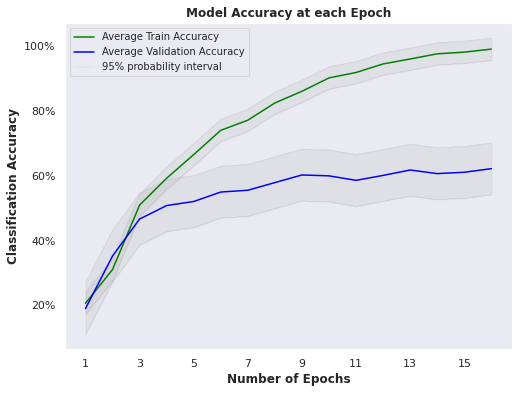

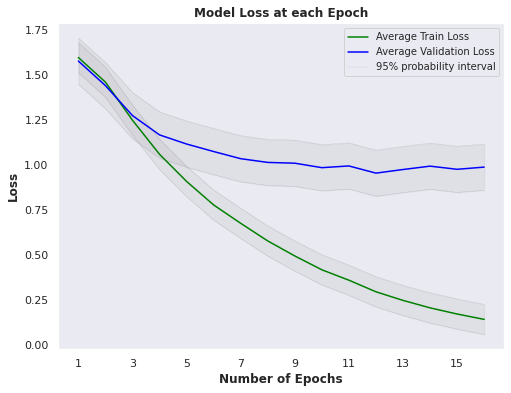

In [0]:
plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_loss, test_accuracy)

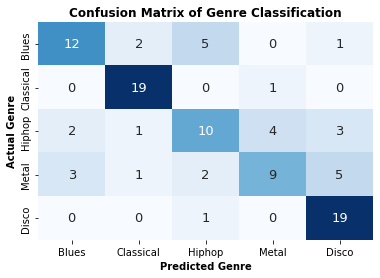

In [0]:
draw_conf_matrix()